<a href="https://colab.research.google.com/github/vinayykkumar/Visionary-Advanced-Image-Recognition-for-the-Next-Era_Infosys_Internship_Oct2024/blob/Shyam/Visionary3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os

Loading and visualizing dataset...
Found 1841 files belonging to 4 classes.


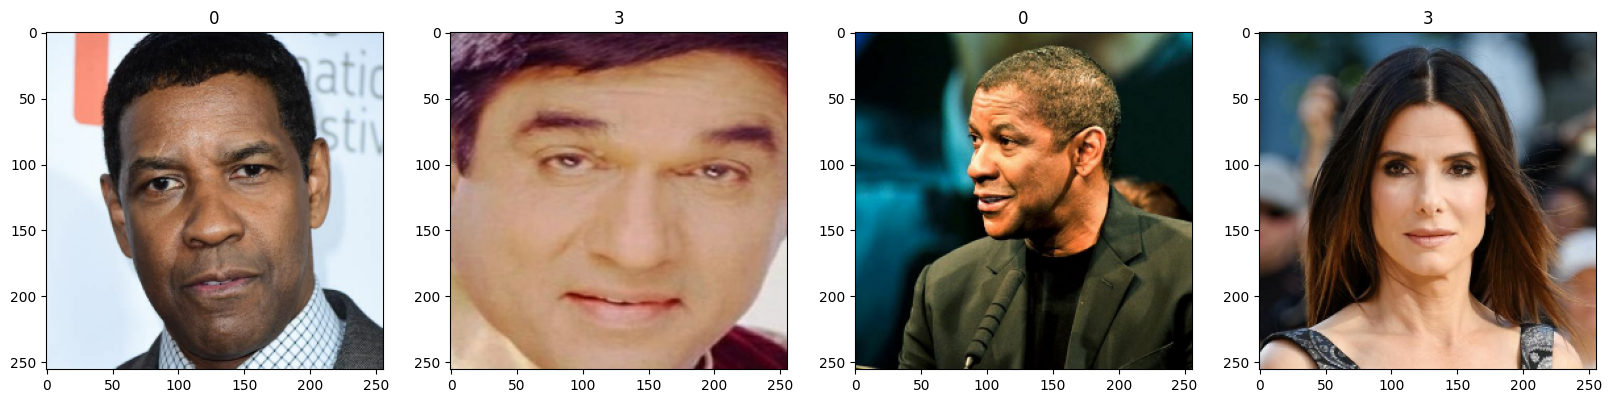

Preprocessing dataset...
Training data shape: (1841, 256, 256, 1)
Training labels shape: (1841,)


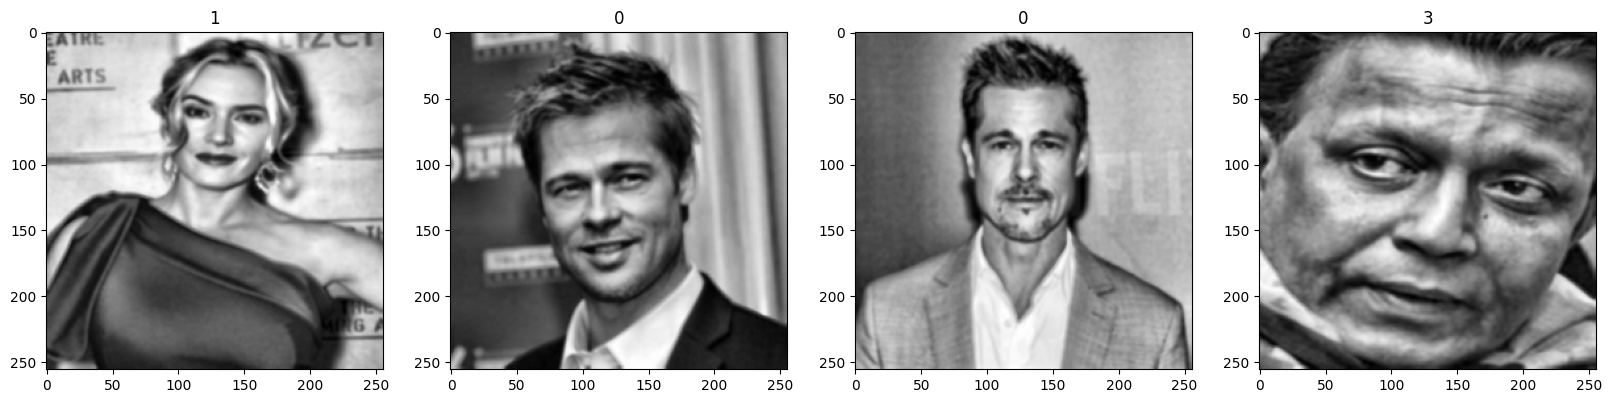

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Path to the dataset
data_dir = '/content/drive/MyDrive/actors_dataset/Indian_actors_faces'  # Replace with your dataset path

# 1. Visualize the Dataset
print("Loading and visualizing dataset...")

# Load the dataset and organize images by class (subfolder names as class labels)
data = tf.keras.utils.image_dataset_from_directory(data_dir)

# Convert the dataset into a NumPy iterator
data_iterator = data.as_numpy_iterator()

# Fetch a batch of images and labels
batch = data_iterator.next()

# Visualize the first 4 images in the batch
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):  # Show first 4 images
    ax[idx].imshow(img.astype(int))  # Convert to int for proper display
    ax[idx].title.set_text(batch[1][idx])  # Display class label as title
plt.show()

# 2. Preprocessing Function
def preprocess_image(image, size=(256, 256)):
    """Resize, normalize, and apply preprocessing to an image."""
    image = cv2.resize(image, size)  # Resize the image
    image = cv2.GaussianBlur(image, (5, 5), 0)  # Apply Gaussian blur
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Ensure the image is 8-bit unsigned before applying CLAHE
    image = image.astype(np.uint8) # This line has been added
    image = clahe.apply(image)  # Apply CLAHE for contrast enhancement
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return np.expand_dims(image, axis=-1)  # Add channel dimension

# 3. Apply Preprocessing to the Dataset
def preprocess_dataset(dataset, size=(256, 256)):
    """Preprocess an entire dataset using the preprocessing function."""
    preprocessed_images = []
    labels = []
    for images, lbls in dataset:
        for img, lbl in zip(images, lbls):
            # Preprocess each image
            preprocessed_img = preprocess_image(img.numpy(), size)
            preprocessed_images.append(preprocessed_img)
            labels.append(lbl.numpy())
    return np.array(preprocessed_images), np.array(labels)

# Preprocess training and validation datasets
print("Preprocessing dataset...")
train_images, train_labels = preprocess_dataset(data)

# Display dataset shape after preprocessing
print(f"Training data shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")

# Optional: Visualize a few preprocessed images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(train_images[:4]):  # Show first 4 preprocessed images
    ax[idx].imshow(img.squeeze(), cmap='gray')  # Show as grayscale
    ax[idx].title.set_text(train_labels[idx])  # Display class label as title
plt.show()


In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_and_save(data, labels, output_dir, class_names, size=(224, 224), images_per_class=300):
    """
    Augments images and saves them to disk.
    Ensures exactly `images_per_class` augmented images are generated per class.

    Args:
        data (array): Array of images.
        labels (array): Array of labels (one-hot encoded).
        output_dir (str): Path to save augmented images.
        class_names (list): List of class names.
        size (tuple): Size to resize images (width, height).
        images_per_class (int): Total augmented images required per class.

    Returns:
        None
    """
    # Data augmentation configuration
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    print("Starting augmentation...")

    # Iterate through each class
    for class_index, class_name in enumerate(class_names):
        # Create class-specific directory
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Filter images for the current class
        class_images = data[np.argmax(labels, axis=1) == class_index]

        # Resize images to target size
        resized_images = [cv2.resize(img, size) for img in class_images]

        # Ensure grayscale images have a channel dimension
        resized_images = [
            np.expand_dims(img, axis=-1) if img.ndim == 2 else img
            for img in resized_images
        ]

        # Calculate how many augmentations to generate per original image
        num_original_images = len(resized_images)
        augmentations_per_image = images_per_class // num_original_images
        extra_images = images_per_class % num_original_images  # Handle leftovers

        counter = 0
        for img_index, image in enumerate(resized_images):
            # Expand dimensions to create a batch of size 1
            image_expanded = np.expand_dims(image, axis=0)

            # Augment the image
            for batch in datagen.flow(image_expanded, batch_size=1):
                # Save augmented image
                save_path = os.path.join(class_dir, f"{class_name}_aug_{counter}.jpg")
                cv2.imwrite(save_path, (batch[0] * 255).astype(np.uint8))  # Convert to [0-255]

                counter += 1
                # Stop if enough images are generated for this class
                if counter >= images_per_class:
                    break

            if counter >= images_per_class:
                break

        # If extra images are needed, duplicate some originals with augmentation
        if counter < images_per_class:
            for img_index, image in enumerate(resized_images[:extra_images]):
                image_expanded = np.expand_dims(image, axis=0)
                for batch in datagen.flow(image_expanded, batch_size=1):
                    save_path = os.path.join(class_dir, f"{class_name}_aug_{counter}.jpg")
                    cv2.imwrite(save_path, (batch[0] * 255).astype(np.uint8))
                    counter += 1
                    if counter >= images_per_class:
                        break

        print(f"Class '{class_name}': {counter} augmented images generated.")

    print("Augmentation complete.")

# Example Usage:
# Replace `train_images` and `train_labels` with your dataset
output_directory = '/content/augmented_dataset'  # Directory to save augmented data
class_names = ['Class1', 'Class2']  # Replace with your actual class names
train_images = np.random.rand(50, 224, 224, 3)  # Example input data
train_labels = np.eye(len(class_names))[np.random.choice(len(class_names), 50)]  # Example one-hot encoded labels

# Generate augmented data and save to disk
augment_and_save(train_images, train_labels, output_directory, class_names, images_per_class=300)



Starting augmentation...
Class 'Class1': 300 augmented images generated.
Class 'Class2': 300 augmented images generated.
Augmentation complete.


In [ ]:
import cv2
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to preprocess an image (applying multiple transformations)
def preprocess_image(img):
    # Grayscale Conversion
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Red and Blue Scaling
    img[:, :, 0] = img[:, :, 0] * random.uniform(0.5, 1.5)  # Blue Channel
    img[:, :, 2] = img[:, :, 2] * random.uniform(0.5, 1.5)  # Red Channel

    # Histogram Equalization
    gray_img = cv2.equalizeHist(gray_img)

    # Resize image to a standard size (128x128)
    img_resized = cv2.resize(img, (128, 128))

    # Brightness/Contrast Adjustment
    alpha = random.uniform(0.7, 1.3)  # Contrast control
    beta = random.randint(-30, 30)    # Brightness control
    img_bright_contrast = cv2.convertScaleAbs(img_resized, alpha=alpha, beta=beta)

    # Blurring
    img_blurred = cv2.GaussianBlur(img_bright_contrast, (5, 5), 0)

    # Edge Detection
    edges = cv2.Canny(img_blurred, 100, 200)

    # Sharpening (using a kernel)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
    img_sharpened = cv2.filter2D(img_bright_contrast, -1, kernel)

    return img_sharpened  # Return the preprocessed image

# Augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the pixel values
    rotation_range=30,  # Random rotations up to 30 degrees
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2,  # Shift images vertically
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zooming
    horizontal_flip=True,  # Random horizontal flipping
    fill_mode='nearest',  # Fill the empty pixels after transformations
    validation_split=0.2  # Split the dataset into training and validation
)

# Load images from directory
train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/actors_dataset/Indian_actors_faces',  # Path to your directory containing the images
    target_size=(128, 128),  # Resize the images to 128x128
    batch_size=32,  # Number of images per batch
    class_mode='categorical',  # Multiple classes
    subset='training'  # This will use the training subset
)

val_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/actors_dataset/Indian_actors_faces',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the validation subset
)

print("Data loading and augmentation completed.")

Found 1474 images belonging to 4 classes.
Found 367 images belonging to 4 classes.
Data loading and augmentation completed.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
import tensorflow as tf # Importing the TensorFlow library
data_dir = '/content/drive/MyDrive/actors_dataset/Indian_actors_faces' # Replace with the correct path

data = tf.keras.utils.image_dataset_from_directory(data_dir)
data = data.map(lambda x,y: (x/255, y))  # Scaling the Image Data,Scaling to [0, 1]
data.as_numpy_iterator().next() # Retrieving a  batch of data


Found 1841 files belonging to 4 classes.


(array([[[[0.17951253, 0.34029683, 0.5128459 ],
          [0.18322611, 0.3440104 , 0.5165594 ],
          [0.17886029, 0.3396446 , 0.5121936 ],
          ...,
          [0.17472762, 0.20878093, 0.2566653 ],
          [0.3447591 , 0.26095185, 0.2448867 ],
          [0.51213473, 0.298943  , 0.2451045 ]],
 
         [[0.17550145, 0.33628577, 0.5088348 ],
          [0.1848008 , 0.34558514, 0.5181341 ],
          [0.1720435 , 0.3328278 , 0.5053768 ],
          ...,
          [0.14260612, 0.19481727, 0.3361979 ],
          [0.21940295, 0.20414226, 0.28098646],
          [0.29624286, 0.22246118, 0.24527061]],
 
         [[0.17792921, 0.33871353, 0.51126254],
          [0.18444657, 0.34523088, 0.5177799 ],
          [0.17578125, 0.33656555, 0.50911456],
          ...,
          [0.26539114, 0.22566158, 0.30862176],
          [0.26326665, 0.18721972, 0.23220024],
          [0.37292695, 0.27910706, 0.287151  ]],
 
         ...,
 
         [[0.06708889, 0.29904354, 0.49628618],
          [0.11794

Split data

In [ ]:
# Define the split ratios
train_split = 0.7  # 70% for training
val_split = 0.2    # 20% for validation
test_split = 0.1   # 10% for testing

# Total number of samples
total_size = len(list(data))  # Get the total size using list(data)

# Calculate the number of samples for each split
train_size = int(total_size * train_split)
val_size = int(total_size * val_split)

# Split the dataset (no need to convert to tf.data.Dataset again)
train = data.take(train_size)  # Take the first 70% for training
val = data.skip(train_size).take(val_size)  # Skip training samples and take the next 20% for validation
test = data.skip(train_size + val_size)  # Skip training + validation samples and use the remaining 10% for testing

# Verify the splits
print(f"Training Size: {len(list(train))} batches")
print(f"Validation Size: {len(list(val))} batches")
print(f"Testing Size: {len(list(test))} batches")

Training Size: 40 batches
Validation Size: 11 batches
Testing Size: 7 batches


Class Distribution: Counter({0: 600, 1: 300})
Training Class Distribution: Counter({0: 480, 1: 240})
Validation Class Distribution: Counter({0: 120, 1: 60})
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 697ms/step - accuracy: 0.5985 - loss: 0.5943 - val_accuracy: 0.6667 - val_loss: 0.6553 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 680ms/step - accuracy: 0.7184 - loss: 0.4646 - val_accuracy: 0.6667 - val_loss: 0.6479 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 748ms/step - accuracy: 0.7797 - loss: 0.4372 - val_accuracy: 0.6778 - val_loss: 0.6130 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 627ms/step - accuracy: 0.7509 - loss: 0.4516 - val_accuracy: 0.6833 - val_loss: 0.5600 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 663ms/step - accuracy: 0.8712 - loss: 0.3517 - val_accuracy: 0.6833 - val_loss: 0.6207 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 643ms/step - accuracy: 0.8803 - loss: 0.3063 - val_accuracy: 0.6833 - val_loss: 0.5680 - learning_rate: 5.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 690ms/step - accuracy: 0.9103 - loss: 0.2616 - 

Final Training Accuracy: 97.22%
Final Validation Accuracy: 98.33%
Model saved at face_recognition_model.h5


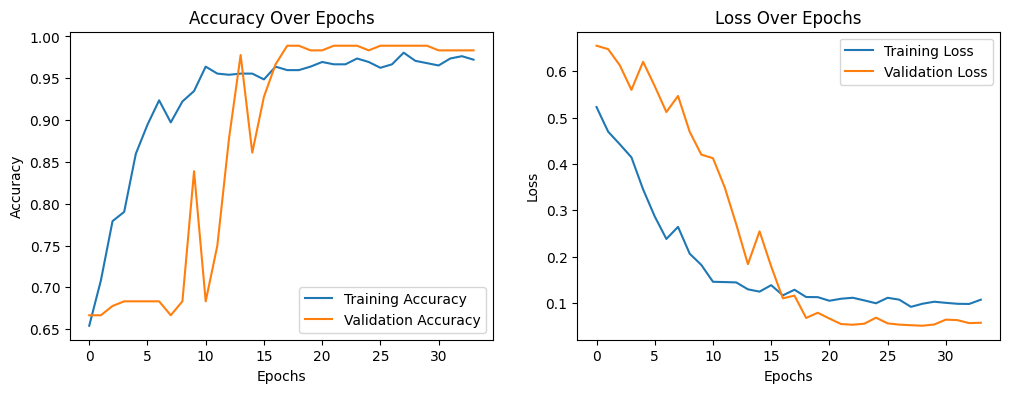

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
from collections import Counter

# Function to load dataset
def load_dataset(dataset_dir, img_size=(128, 128)):
    """
    Load images and labels from the specified dataset directory.

    Args:
        dataset_dir (str): Path to dataset directory.
        img_size (tuple): Target size for resizing images.

    Returns:
        tuple: Tuple containing image data (X), labels (y), and LabelEncoder instance.
    """
    X, y = [], []
    label_names = []

    for person_name in os.listdir(dataset_dir):
        person_folder = os.path.join(dataset_dir, person_name)
        if not os.path.isdir(person_folder):
            continue

        label_names.append(person_name)
        for img_name in os.listdir(person_folder):
            img_path = os.path.join(person_folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(person_name)

    X = np.array(X, dtype='float32') / 255.0  # Normalize images
    y = np.array(y)

    # Encode labels to integers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    print(f"Class Distribution: {Counter(y)}")  # Check class distribution
    return X, y, label_encoder

# Function to build the improved model
def build_model(input_shape, num_classes, learning_rate=0.0001, weight_decay=1e-4):
    """
    Build and compile a CNN model with Batch Normalization and L2 regularization.

    Args:
        input_shape (tuple): Shape of the input images.
        num_classes (int): Number of output classes.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 regularization factor).

    Returns:
        model: Compiled CNN model.
    """
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
    ])

    loss = 'categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy'
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss, metrics=['accuracy'])
    return model

# Function to plot training history
def plot_training_history(history):
    """
    Plot training and validation accuracy/loss over epochs.
    """
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Function to schedule learning rate
def scheduler(epoch, lr):
    """
    Learning rate scheduling: reduce learning rate by a factor of 0.5 every 5 epochs.
    """
    if epoch % 5 == 0 and epoch > 0:
        lr = lr * 0.5
    return lr

def train_model(dataset_dir, output_model_path, img_size=(128, 128), learning_rate=0.0001, weight_decay=1e-4):
    """
    Train and save a face recognition model with debugging enhancements.

    Args:
        dataset_dir (str): Path to dataset directory.
        output_model_path (str): Path to save the trained model.
        img_size (tuple): Target size for resizing images.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 regularization factor).
    """
    # Load dataset
    X, y, label_encoder = load_dataset(dataset_dir, img_size)
    num_classes = len(np.unique(y))

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Encode labels for multi-class classification
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_val = to_categorical(y_val, num_classes=num_classes)

    print(f"Training Class Distribution: {Counter(np.argmax(y_train, axis=1))}")
    print(f"Validation Class Distribution: {Counter(np.argmax(y_val, axis=1))}")

    # Build the model
    model = build_model(
        input_shape=(img_size[0], img_size[1], 3),
        num_classes=num_classes,
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )

    # Data Augmentation
    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
    datagen.fit(X_train)

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the model
    history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                        validation_data=(X_val, y_val),
                        epochs=50,
                        callbacks=[early_stopping, lr_scheduler])

    # Print final accuracies
    print(f"Final Training Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")

    # Save the model and label encoder
    model.save(output_model_path)
    np.save(output_model_path + "_labels.npy", label_encoder.classes_)
    print(f"Model saved at {output_model_path}")

    # Plot training history
    plot_training_history(history)


# Example Usage
dataset_directory = "/content/augmented_dataset"  # Path to your augmented dataset
output_model_file = "face_recognition_model.h5"  # Path to save the model

train_model(dataset_directory, output_model_file)




Selected image: /content/drive/MyDrive/actors_dataset/Indian_actors_faces/Label 1/050_a5810700.jpg


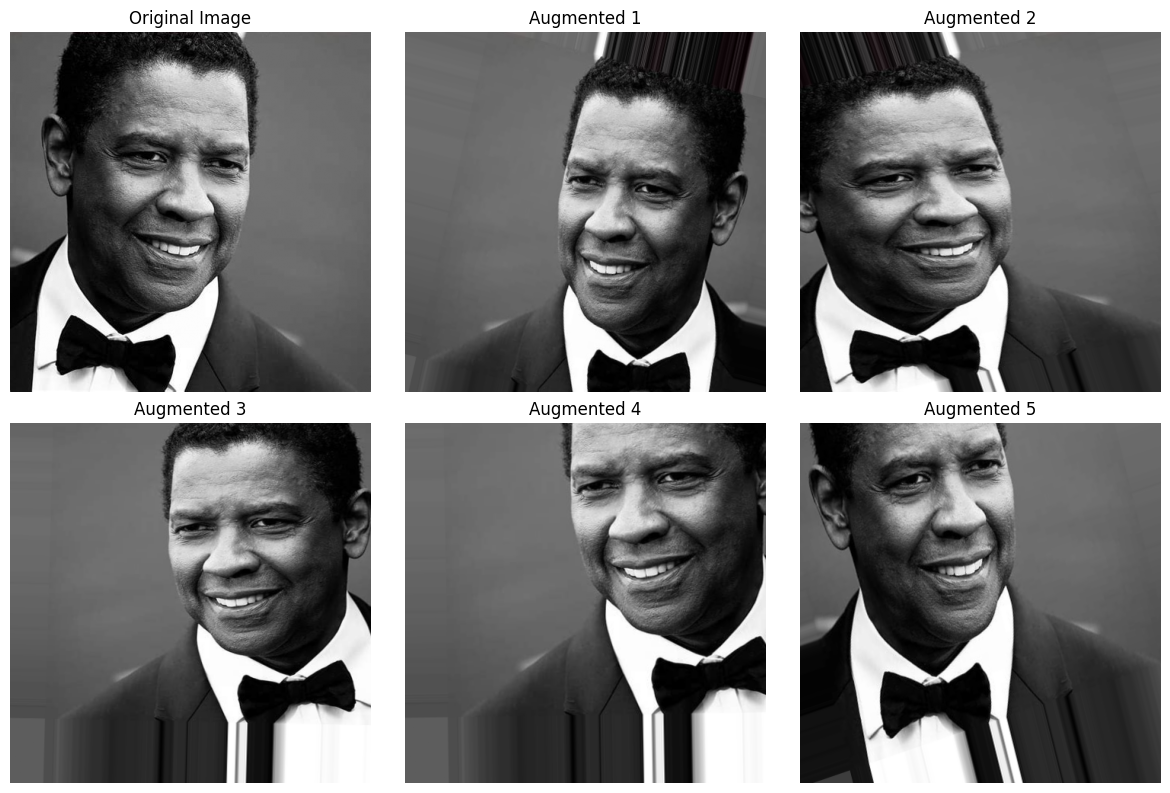

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

# Define the directory containing the images
image_dir = "/content/drive/MyDrive/actors_dataset/Indian_actors_faces/Label 1"

# List all files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Check if there are images in the directory
if len(image_files) > 0:
    # Select a random image
    image_file = np.random.choice(image_files)
    image_path = os.path.join(image_dir, image_file)
    print(f"Selected image: {image_path}")

    # Load the image
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for compatibility
        img_array = img_to_array(img)              # Convert to array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Initialize the ImageDataGenerator
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Generate augmented images
        aug_iter = train_datagen.flow(img_array, batch_size=1)

        # Plot original image and augmented versions
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))

        # Display original image
        axes[0, 0].imshow(img / 255)  # Normalize for Matplotlib
        axes[0, 0].set_title("Original Image")
        axes[0, 0].axis('off')

        # Generate and display augmented images
        for i in range(1, 6):  # Start from index 1 because 0 is for the original image
            augmented_img = next(aug_iter)  # Get the next augmented image
            axes[i // 3, i % 3].imshow(augmented_img[0])  # Use [0] to get the image from the batch
            axes[i // 3, i % 3].set_title(f"Augmented {i}")
            axes[i // 3, i % 3].axis('off')

        plt.tight_layout()
        plt.show()

    else:
        print(f"Error: Could not load the selected image file: {image_path}")

else:
    print(f"Error: No images found in the directory: {image_dir}")

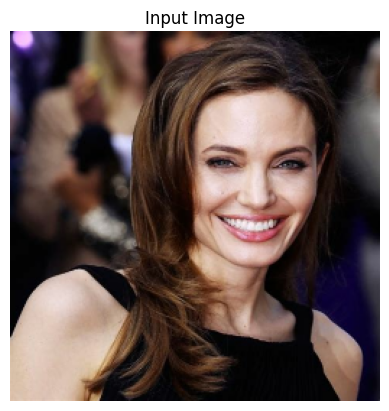

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Predicted emotion is: Happy


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os # Import os module for file handling

# Load and preprocess the image
def preprocess_image(image_path, target_size=(256, 256)):

    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)  # Decode as RGB image
    img = tf.image.resize(img, target_size)  # Resize to model's input size
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img.numpy()

# Predict function
def predict_emotion(model, image_path, class_names):

    # Get a list of image files in the directory
    image_files = [f for f in os.listdir(image_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Check if there are images in the directory
    if len(image_files) == 0:
        print(f"Error: No images found in the directory: {image_path}")
        return None  # Or handle the case appropriately

    # Select the first image (or you can modify to select a random image)
    selected_image_path = os.path.join(image_path, image_files[0])

    img = preprocess_image(selected_image_path) # Preprocess the selected image
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # Expand dimensions to match model input
    yhat = model.predict(np.expand_dims(img, axis=0))

    # Binary classification: select class based on threshold (0.5)
    predicted_class_index = 0 if yhat[0][0] < 0.5 else 1
    predicted_class = class_names[predicted_class_index]

    print(f"Predicted emotion is: {predicted_class}")
    return predicted_class

# Example Usage
class_names = ['Happy', 'Sad']  # Define your class names
image_path = '/content/drive/MyDrive/actors_dataset/Indian_actors_faces/Label 1'  # Path to the input image DIRECTORY

model = tf.keras.models.load_model('/content/face_recognition_model.h5')

# Predict emotion
predicted_emotion = predict_emotion(model, image_path, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Class Index: 1
Predicted Class Name: Label 2


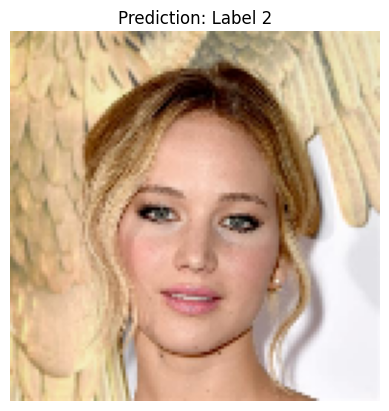

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(128, 128)):  # Adjust size to match training size
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)  # Decode as RGB image
    img = tf.image.resize(img, target_size)  # Resize to the same size as training data
    img = img / 255.0  # Normalize to [0, 1]
    return img.numpy()

new_image_path = "/content/drive/MyDrive/actors_dataset/Indian_actors_faces/Label 2/026_cf5be1f1.jpg"
preprocessed_image = preprocess_image(new_image_path)

# Assuming you have the class names defined as
class_Labels = ['Label 1', 'Label 2', 'Label 3', 'Label 4']  # Replace with actual class names

if preprocessed_image is not None:
    # Expand dimensions to match model input (batch size of 1)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

    # Predict the class
    prediction = model.predict(preprocessed_image)
    predicted_class_index = np.argmax(prediction)  # Get the index of the highest probability
    predicted_class_name = class_Labels[predicted_class_index]  # Map index to class label

    print(f"Predicted Class Index: {predicted_class_index}")
    print(f"Predicted Class Name: {predicted_class_name}")
    #print(f"Prediction Probabilities: {prediction}")  # Check the probability values

    # Plot the input image for reference
    plt.imshow(tf.image.resize(tf.image.decode_image(tf.io.read_file(new_image_path), channels=3), (128, 128)).numpy().astype(int))
    plt.title(f"Prediction: {predicted_class_name}")
    plt.axis('off')
    plt.show()



In [ ]:
# Predict the class probabilities
# Get images and labels from the test dataset
from sklearn.metrics import accuracy_score # Import accuracy_score

test_images = []
test_labels = []
for images, labels in test:
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

test_images = np.array(test_images)  # Convert to NumPy array
predictions = model.predict(test_images)

# Convert probabilities to class labels (for multi-class classification)
predicted_classes = np.argmax(predictions, axis=1)

# Since test_labels are one-hot encoded, convert them to single-label format:
true_classes = np.argmax(np.array(test_labels), axis=1)  # Convert to single-label format

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy}") # Removed extra space before print statement


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Accuracy: 0.55


 Matrix

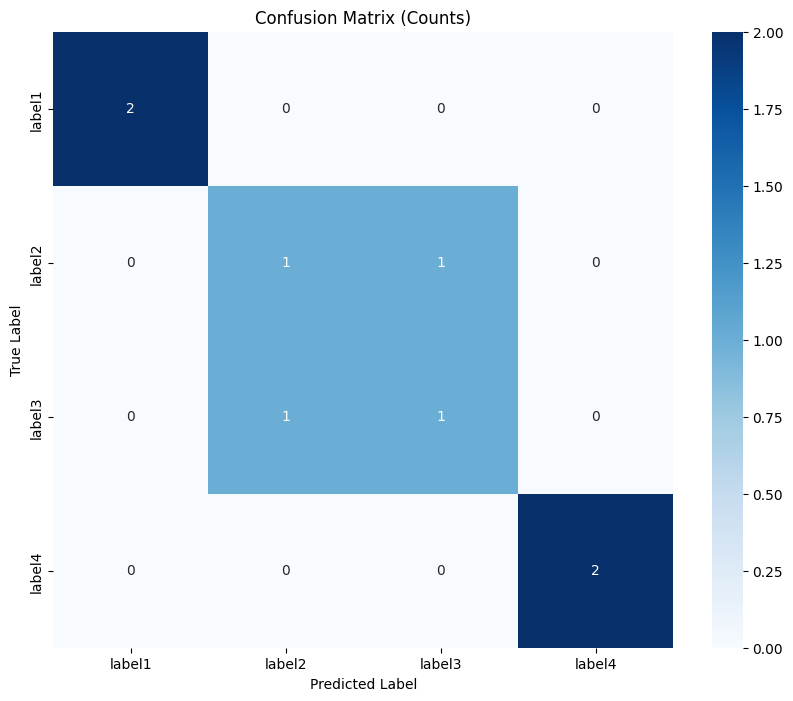

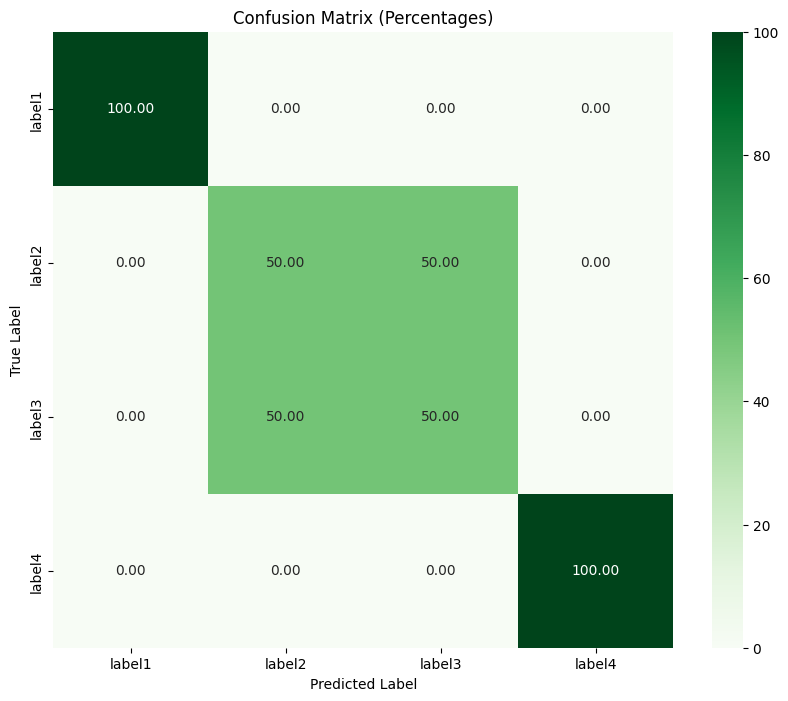


Detailed Confusion Matrix Breakdown:
Class 'label1':
  True Positives: 2
  False Positives: 0
  False Negatives: 0
  True Negatives: 6

Class 'label2':
  True Positives: 1
  False Positives: 1
  False Negatives: 1
  True Negatives: 5

Class 'label3':
  True Positives: 1
  False Positives: 1
  False Negatives: 1
  True Negatives: 5

Class 'label4':
  True Positives: 2
  False Positives: 0
  False Negatives: 0
  True Negatives: 6



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Calculate percentages for readability
    cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

    plt.figure(figsize=(10, 8))

    # Plot heatmap for counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix (Counts)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Plot heatmap for percentages
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix (Percentages)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Print detailed breakdown
    print("\nDetailed Confusion Matrix Breakdown:")
    for i, class_name in enumerate(class_names):
        print(f"Class '{class_name}':")
        print(f"  True Positives: {cm[i, i]}")
        print(f"  False Positives: {cm[:, i].sum() - cm[i, i]}")
        print(f"  False Negatives: {cm[i, :].sum() - cm[i, i]}")
        print(f"  True Negatives: {cm.sum() - (cm[:, i].sum() + cm[i, :].sum() - cm[i, i])}\n")

# Assuming you have true classes and predicted classes from your model
# Replace with actual data
true_classes = [0, 1, 2, 3, 0, 1, 2, 3]  # Example true labels
predicted_classes = [0, 1, 1, 3, 0, 2, 2, 3]  # Example predicted labels

# Define the class names as used in your project
class_names = ['label1', 'label2', 'label3', 'label4']

# Call the function with true and predicted classes
plot_confusion_matrix(true_classes, predicted_classes, class_names)
